This python notebook was created by referencing the following paper and links: 

[1] "Stochastic Modeling of MEMS Inertial Sensors" http://www.cit.iit.bas.bg/cit_2010/v10-2/31-40.pdf

[2] https://github.com/hanley6/IMUSensorModels

[3] https://www.youtube.com/watch?v=P1OEoA70YJo
    

# "Stochastic Modeling of MEMS Inertial Sensors"
Inertial Sensor Errors: 

    1) Deterministic error: 
        constant bias, scale factors, axis nonorthogonality, axis misalignment
    
    2) Stochastic error: 
        random error (noises) => modeled as stochastic processes
        
The MEMS gyroscope noise:
    - Bias instability: 
      This is a stationary stochastic process which may be considered as a low order zero-mean Gauss-Markov process.
    - Angular random walk:
      This is an angular error process which is due to 'white noise' in angular rate. 
    - Rate random walk: 
      This is a rate error due to 'white noise' in angular acceleration. 
    - Discretization error: 
      This is an error representing the quantization noise. 
      
The MEMS acceleration noise: 
    - Bias instability
    - Velocity random walk: 
      This is a velocity error due to white noise in acceleration.
    - Acceleration random walk: 
      This is an acceleration error due to white noise in jerk. 
    - Discretization error
    
Methodology using the frequency-domain and time-domain characteristics of the sensors noises. 
Gyroscope and accelerometer noises have similar second-order models which are appropriate for usage in the development of Kalman filters for naviation and control systems. 
    
      



In [255]:
import scipy.io as sio
import numpy as np
from numpy import median
import math
from scipy import signal
import matplotlib.pyplot as plt

## Allan function : 

The following document was used to create the code: "Stochastic Modeling of MEMS Inertial Sensors" 
http://www.cit.iit.bas.bg/cit_2010/v10-2/31-40.pdf
Section 2, equaton (2)

Similarly, "the following document can be referenced:
"Allan Variance: Noise Analysis for Gyroscopes."
Document Number: AN5087. Rev. 0, 2/2015.
http://www.nxp.com/files/sensors/doc/app_note/AN5087.pdf?fasp=1&WT_TYPE=Application%20Notes&WT_VENDOR=FREESCALE&WT_FILE_FORMAT=pdf&WT_ASSET=Documentation&fileExt=.pdf" [2]

In [256]:
def allan(meas,fs,pts):
    #   Inputs:
    #       meas = set of measurements (number of rows is number of
    #       measurements)
    #       fs = frequency of measurements
    #       pts = number of points to plot in Allan variance
    #   Outputs:
    #       T = Time spans of Allan variance points
    #       sigma = Allan standard deviation

    # Figure out how big the output data set is
    N = meas.shape[0]
    M = meas.shape[1]

    # print(N)
    # print(M)

    # Determine largest bin size
    n = 2**np.array(np.matrix(np.arange(math.floor(math.log2(N/2))+1)).H)
    maxN = n[-1]
    endLogInc = math.log10(maxN)


    # Create log spaced vector average factor
    m = np.array(np.unique(np.ceil(np.logspace(0,endLogInc,num=pts))).astype(int))[np.newaxis].T


    # t0 = sample interval
    t0 = 1/fs

    # T = length of time for each cluster
    T = m*t0

    # Integration of samples over time to obtain output angle? 

    theta = meas.cumsum(axis=0)/fs

    # Array of dimensions (cluster periods) X (#variables) 
    sigma2 = np.zeros((len(T),M),float)

    # Loop over the various cluster sizes
    for i in range(len(m)):
        # Implements the summation in the AV equation
        for k in range((N-2*m[i])[0]):
            sigma2[i,] = sigma2[i,] + (theta[k+2*m[i].astype(int),][0]- 2*theta[k+m[i].astype(int),][0] + theta[k,][0])**2

    sigma2 = sigma2/np.kron(np.ones((1,M)),(2*T**2*(N-2*m)))
    sigma = np.sqrt(sigma2)

    return T,sigma

In [257]:
# Finding the next smallest power of 2 larger than the given input
# Used for Power Spectral Densities function
def nextpow2(i):
        n = 1
        while n < i: n *= 2
        return n

In [258]:
# Reference from [2]
def PowerSpectralDensitities(data, fs):

    ex = data.T[0]

    tsamp = 1/fs
    L = len(ex)

    NFFT = nextpow2(L)
    Y = np.fft.fft(ex,NFFT)/L
    f = fs/2*np.linspace(0,1,NFFT/2+1)

    amp = 2*abs(Y[0:int(NFFT/2 +1)])
    return amp, f

In [259]:
def SensorStocModel( sensor_meas, B, K, Tc, fs, bias, sig_gyro_noise, rrw, sig_w):
# SENSORSTOCMODEL outputs a sensor measurement corrupted by a noise model. 
# This models only the stochastic component of the sensor. Deterministic
# errors, such as scale and turn-on bias, should be applied to the 
# sensordata input prior to using this function. The following paper is used
# as a reference for this function:
# P. Petkov and T. Slavov. "Stochastic Modeling of MEMS Inertial Sensors."
# Cybernetics and Information Technologies. Vol. 10. No. 2. pp. 31-40.
# 2010.
#   Inputs:
#           sensordata = noise free sensor reading. (for example, if a
#                        gyroscope, this would be the true angular velocity
#                        about the sensor). This input also assumes other
#                        deterministic sensor errors such as scale factor 
#                        and turn-on bias are already applied.
#           B = Mean Square Value of Bias Instability
#           K = Mean Square Value of Rate Random Walk
#           T = Time Window at Minimum of Allan Variance
#           freq = Frequency of Sensor Measurements
#           bias = Current Value of Bias Instability Contribution
#           sig_meas = Standard Deviation of Total Sensor Measurement
#                      (assuming error of mean zero)
#           rrw = Current Value of Rate Random Walk Contribution
#           sig_w = Standard deviation used in rate random walk
#                   contribution so that low frequency of RRW PSD matches 
#                   low frequency of the PSD from dataset of sensor data
#   Outputs:
#           sensor_meas = Output Sensor Measurement
#           bias = Revised Value of Bias Instability Contribution
#           rrw = Revised Value of Rate Random Walk Contribution
#   Modified by Eun Sun Lee (4/20/2018) to python code form matlab code written by David Hanley (9/28/2016)

##------------------------- Bias Instability -------------------------##

    # Period of sensor measurements
    dt = 1/fs
    # Set up discrete time bias instability dynamics 
    a_d = np.exp(-dt/Tc)
    b_d = Tc - Tc*np.exp(-dt/Tc)
    # Equation 6 in [1] but error in the paper so edited. 
    sig_eta = B*np.sqrt(1-a_d**2)/b_d
    eta = sig_eta*np.random.randn(1)[0]
    # Compute next bias instability state 
    bias = a_d * bias + b_d *eta
    
##----------------------- End Bias Instability -----------------------##

##------------------------- Rate Random Walk -------------------------##
    # Equation 7,8 from [1]
    # w in equation 7 is a white noise with unknown variance sigma2 
    
    # Compute next rate random walk state
    rrw = rrw + K*dt*sig_w*np.random.randn(1)[0]
    
##----------------------- End Rate Random Walk -----------------------##

##------------------------- Angle Random Walk ------------------------##
    # Compute the standard deviation of the angle random walk 
    sig_arw = np.sqrt(sig_gyro_noise**2 - (K*dt*sig_w)**2 - B**2)
    # Find angle random walk contribution
    # Equation 9 from [1]
    arw = sig_arw*np.random.randn(1)[0]
##--------------------- End Angle Random Walk ------------------------##

    # Compute Total Sensor Noise Contribution
    # Equation 10 from [1]
    sensor_noise = bias + arw + rrw
    
        # Compute Total Sensor Measurment 
    sensor_meas = sensor_meas + sensor_noise
    return sensor_meas, bias, rrw



In [260]:
def SensorDetModel(sensordata, S, Bf):
# SENSORDETMODEL Outputs corrupted sensor measurement due to deterministic 
# errors. This approach ignore cross coupling effects, g-sensitive bias, and
# vibro-pendulous error since the input is only the error free sensor 
# output. This approach is based on:
# D. Titterton and J. Weston. "Strapdown Inertial Navigation Technology." 
# The Institution of Engineering and Technology. 2nd Edition. 2004.
# 	Inputs:
#           sensordata = noise free sensor reading. (for example, if a
#                        gyroscope, this would be the true angular velocity
#                        about the sensor).
#           S = Current Value of Bias Instability Contribution
#           Bf = Current Value of Rate Random Walk Contribution
#   Outputs:
#           sensor_meas = Output Sensor Measurement with Deterministic
#                         Errors
#   Adapted from: https://github.com/hanley6/IMUSensorModels/blob/master/Matlab%20Example/SensorDetModel.m

# Compute corrupted sensor measurement due to deterministic errors
    sensor_meas = (1.0 + S)*sensordata + Bf
    return sensor_meas

"The stochastic discrete-time model of the gyro sensors is derived on the base of the gyro noise measured at rest."[1]

In the Allan Variance plot generated from the code below, three components of noise can be derived. 
- Bias instability => B (deg/s)
- Angular Random Walk => N (deg/s^1/2)
- Rate Random Walk => K (deg/s^1/2)

* Descretization error is neglegible

599
599


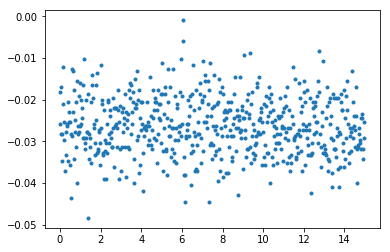

In [261]:
import csv
k = 0
time_val = []
gyro = []
# with open('llll.csv','r') as f: 
#     reader = csv.reader(f)
#     for row in reader: 
#         if k >1 and k < 500:
#             time_val.append(row[0])
#             gyro.append(row[10])
#         k = k + 1
        
with open('IMU_test_straight_square_circle_20180402_191102.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if k> 15000 and k < 15600:
        #if k > 15000 and k < 15400:
        # if k >10000 and k < 16800:#8828: 
            gyro.append(row[0])
        
                #print(k)
                #print(row[3])#time_val.append(1)
#             time_val.append(row[0])
#             gyro.append(row[4])
        k = k + 1
start = 0
stop = len(gyro)/40

time_val = np.linspace(start,len(gyro)/40,len(gyro))
print(len(gyro))
print(len(time_val))

time_k = np.array(time_val).astype(np.float)
gyro_k = np.array(gyro).astype(np.float)
meas = gyro_k[np.newaxis].T
time = time_k[np.newaxis].T

# print(len(meas))
plt.plot(time_k, gyro_k,'.')
plt.show()

In [262]:
# #Load Data
# mat_contents = sio.loadmat('Data002.mat')
# Time = mat_contents['Time']
# accel = mat_contents['accel']
# gyro_rev = mat_contents['gyro_rev']
# time_rev = mat_contents['time_rev']

# data_len =2000
# # Parse data
# meas = np.array(gyro_rev[0][0:data_len])[np.newaxis].T
# time = np.array(time_rev[0][0:data_len])[np.newaxis].T
# pts = len(time)



In [263]:
# Removing constant bias [1]
meas = meas - np.mean(meas)

# Compute sampling frequency
fs = 1/np.median(np.diff(time.T))
# print(fs)

# Compute Allan Variance from data
T, sigma = allan(meas,fs,pts)

# Compute PSD from Data
Pxx, f = PowerSpectralDensitities(meas, fs)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


In [264]:
print(fs)

39.93322203672841


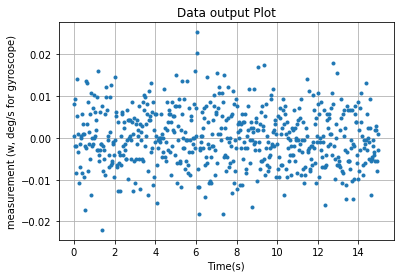

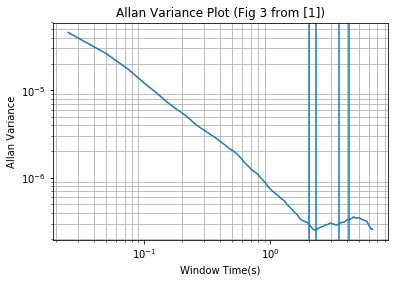

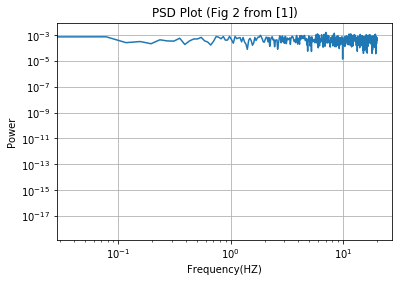

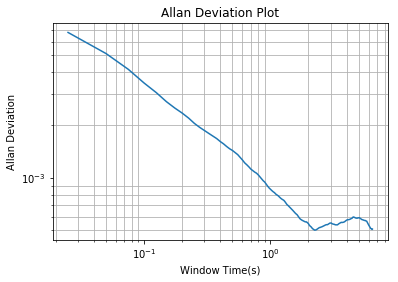

In [265]:
##--------------------------- Plot Results ---------------------------##
# Data Output
plt.plot(time, meas, '.')
plt.xlabel('Time(s)')
plt.ylabel('measurement (w, deg/s for gyroscope)')
plt.title('Data output Plot')
plt.grid()
plt.show()

# Allan Variance
plt.loglog(T,sigma**2)
a = 2.0
b = 2.3
c = 3.5
d = 4.2
plt.axvline(x=a)
plt.axvline(x=b)
plt.axvline(x=c)
plt.axvline(x=d)
plt.xlabel('Window Time(s)')
plt.ylabel('Allan Variance')
plt.title('Allan Variance Plot (Fig 3 from [1])')
plt.grid(which = 'minor')
plt.show()

# Power Spectral Densities
plt.loglog(f,Pxx)
plt.xlabel('Frequency(HZ)')
plt.ylabel('Power')
plt.title('PSD Plot (Fig 2 from [1])')
plt.grid()
plt.show()

# Allan Deviation
plt.loglog(T,sigma)
plt.xlabel('Window Time(s)')
plt.ylabel('Allan Deviation')
plt.title('Allan Deviation Plot')
plt.grid(which = 'minor')
plt.show()
##--------------------------- Plot Results ---------------------------##

##--------------------------------------------------------------------##
##------------------ End Data Loading and Analysis -------------------##
##--------------------------------------------------------------------##

## Computation of noise parameters

bias instability Tx'(t) + x(t) = v(t)


B:  0.000756322639731816
N:  0.000757771182716254
K:  0.0004975688433149794
sig_gyro_noise:  0.006851962878487367
T:  2.25376254180599


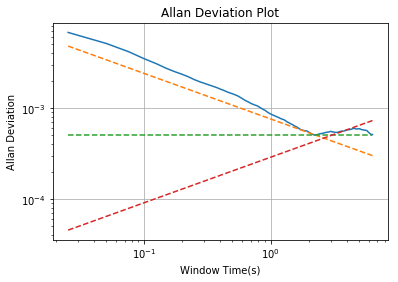

In [266]:
##--------------------------------------------------------------------##
##--------------- Compute Critical System Parameters -----------------##
##--------------------------------------------------------------------##


# Find Allan Deviation Along Angle Random Walk Portion of Curve
tau_low = a
tau_high = b

count = 1
tau = []
ADev = []
for i in range(len(T)):
    if ((T[i] >= tau_low) and (T[i] <= tau_high)):
        tau.append(T[i][0])
        ADev.append(sigma[i][0])

# print(tau)
# print(ADev)

# Use bisection method to compute N (the mean square value of the angle
# random walk noise)
higher = 1
lower = 1e-10

for i in range(100):
    N = (higher+lower)/2
    error = sum(N/np.sqrt(tau)-ADev)
    if error < 0:
        lower = N
    else: 
        higher = N
        
# Find Allan Deviation Along Rate Random Walk Portion of Curve
tau_low = c
tau_high = d

count = 1
tau_right = []
ADev_right = []
for i in range(len(T)):
    if ((T[i] >= tau_low) and (T[i] <= tau_high)):
        tau_right.append(T[i][0])
        ADev_right.append(sigma[i][0])
        
# print(tau_right)
higher = 1
lower = 1e-10

# Use bisection method to compute K (the mean square value of the rate
# random walk noise)
for i in range(100):
    K = (higher+lower)/2
# #     print(np.divide(tau_right,3))
    error = sum(K*np.sqrt(np.divide(tau_right,3))-ADev_right)

    if error < 0:
        lower = K
    else: 
        higher = K

# Find the Time Window at Minimum of Allan Variance
index = np.argmin(sigma)
Tc = T[index][0]

# Find B (the mean square value of the bias instability)
B = min(sigma)[0]/np.sqrt(2*math.log(2)/math.pi)

# Find the standard deviation of total sensor measurements (assuming error
# mean is zero)
sig_gyro_noise = np.sqrt(np.var(meas))

# Choose standard deviation used in rate random walk contribution so that 
# low frequency of RRW PSD matches low frequency of the PSD from dataset of 
# sensor data
sig_w = 10

# Display Parameter Results
print("B: ", B)
print("N: ", N)
print("K: ", K)
print("sig_gyro_noise: ", sig_gyro_noise)
print("T: ", Tc)

# Show resulting parameter lines on Allan deviation plot
plt.loglog(T,sigma)
plt.loglog(T, N/np.sqrt(T),'--')
plt.loglog(T,B*np.sqrt(2*math.log(2)/math.pi)*np.ones(len(T)),'--')
plt.loglog(T,K*np.sqrt(T/3),'--')
plt.xlabel('Window Time(s)')
plt.ylabel('Allan Deviation')
plt.title('Allan Deviation Plot')
plt.grid()
plt.show()

##--------------------------------------------------------------------##
##------------- End Compute Critical System Parameters ---------------##
##--------------------------------------------------------------------##


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


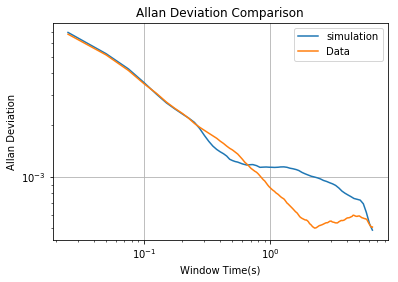

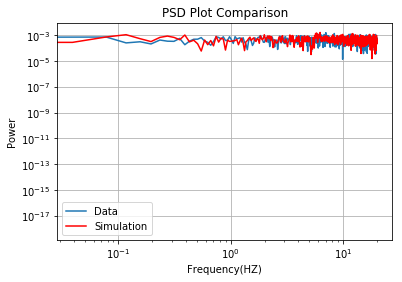

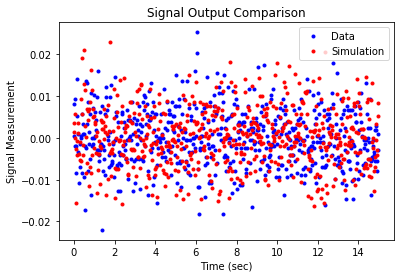

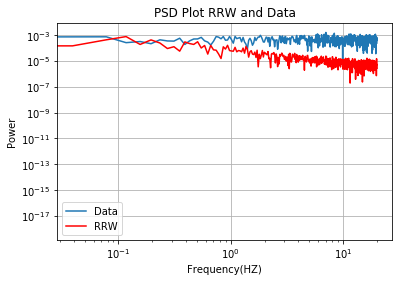

In [267]:
##--------------------------------------------------------------------##
##----------------------- Test Simulation ----------------------------##
##--------------------------------------------------------------------##

# Initialize Bias, Rate Random Walk, Simulation Measurement Vector, and 
# Rate Random Walk Vector 

bias = 0
rrw = 0
S = 0
Bf = 0

sim_meas = np.zeros((len(meas),1))
rrw_save = np.zeros((len(meas),1))


# Run Simulation Over Same Time and at Same Data Rate as Test Data
sim_meas = []
rrw_save = []
for i in range(len(meas)):
    sensor_meas = SensorDetModel(0,S,Bf)
    
    sensor_meas, bias, rrw = SensorStocModel( sensor_meas, B, K, Tc, fs, bias, sig_gyro_noise, rrw, sig_w)
    
    sim_meas.append(sensor_meas)
    rrw_save.append(rrw)
    
sim_meas = np.array(sim_meas)[np.newaxis].T
rrw_save = np.array(rrw_save)[np.newaxis].T
# print(rrw_save)

# Compute Allan Variance of Simulation Data 
[T_val, sigma_val] = allan(sim_meas,fs,100)
# Compute PSD of Simulation Data
[Pxx_val, f_val] = PowerSpectralDensitities(sim_meas, fs)
# Compute PSD of Rate Random Walk Data
[Pxx_rrw, f_rrw] = PowerSpectralDensitities(rrw_save, fs)

# Compare Data Allan Deviation and Simulation Allan Deviation
plt.loglog(T_val,sigma_val,T,sigma)
labels = ['simulation', 'Data']
plt.legend(labels)
plt.xlabel('Window Time(s)')
plt.ylabel('Allan Deviation')
plt.title('Allan Deviation Comparison')
plt.grid()
plt.show()

# Compare Data Power Spectral Density and Simulation Power Spectral Density
plt.loglog(f,Pxx, f_val, Pxx_val,'r')
plt.xlabel('Frequency(HZ)')
plt.ylabel('Power')
plt.title('PSD Plot Comparison')
plt.legend(['Data','Simulation'])
plt.grid()
plt.show()

# Compare Data Measurements with Simulation Measurements
plt.plot(time,meas,'b.')
plt.plot(time,sim_meas,'r.')
plt.xlabel('Time (sec)')
plt.ylabel('Signal Measurement')
plt.grid()
plt.title('Signal Output Comparison')
plt.legend(['Data','Simulation'])
plt.grid()
plt.show()

# Calculate the closeness of both measured gyro noise and noise generated by the gyro noise model 
num = np.sqrt(np.sum((meas- sim_meas)**2))
den = np.sqrt(np.sum(meas**2))
# print(num)
# print(den)
fit = (1 - num/den)*100

# print("The closeness of measured and simulated signals: ", fit)


# Compare Data PSD with Rate Random Walk Power Spectral Density
plt.loglog(f,Pxx, f_rrw, Pxx_rrw,'r')
plt.xlabel('Frequency(HZ)')
plt.ylabel('Power')
plt.title('PSD Plot RRW and Data')
plt.legend(['Data','RRW'])
plt.grid()
plt.show()


##--------------------------------------------------------------------##
##--------------------- End Test Simulation --------------------------##
##--------------------------------------------------------------------##

# from sklearn.metrics import r2_score
# print(r2_score(sim_meas, meas))


In [269]:
# # from sklearn.metrics import r2_score
# print(r2_score(sim_meas, meas))

# # Compare Data PSD with Rate Random Walk Power Spectral Density
# plt.loglog(f,Pxx)#, f_rrw, Pxx_rrw,'r')
# plt.xlabel('Frequency(HZ)')
# plt.ylabel('Power')
# plt.title('PSD Plot RRW and Data')
# plt.legend(['Data','RRW'])
# plt.grid()
# plt.show()

-0.9677488686525062
